In [1]:
#Setting up notebook
%matplotlib notebook

In [2]:
#Import useful libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os

#Import UFSS
import ufss

In [3]:
# these are helper functions defined in ufss for convenient forward and backward dft
# they use pyfftw
ift = ufss.signals.SignalProcessing.ift1D
ft = ufss.signals.SignalProcessing.ft1D

In [4]:
folder = 'circular_test'
os.makedirs(folder,exist_ok=True)

## Constructing the Hamiltonian

In [5]:
# since this system consists of 3 energy levels, we construct three occupation operators:
# Ground state:
n0 = np.zeros((3,3))
n0[0,0] = 1
# first excited state:
n1 = np.zeros((3,3))
n1[1,1] = 1
#second excited state:
n2 = np.zeros((3,3))
n2[2,2] = 1

# the Hamiltonian is given as
epsilon = 1 # energy gap between ground and lowest excited state (rotated away)
depsilon = 0.2 # energy gap between lowest excited state and next excited state
H = 0*n0 + epsilon * n1 + (epsilon + depsilon) * n2
II = np.eye(H.shape[0]) #Identity of same dimension as H
print(H)

[[0.  0.  0. ]
 [0.  1.  0. ]
 [0.  0.  1.2]]


In [6]:
# Take H and split it into the ground-state manifold (GSM) and the singly-excited manifold (SEM)
H_GSM = H[:1,:1]
H_SEM = H[1:,1:]

# Normally we would now diagonalize H_GSM anad H_SEM separately.  However, they are already diagonal!

# eigenvalues are the diagonal entries of H
eigenvalues = {'0':H_GSM.diagonal(),'1':H_SEM.diagonal()}

# matrix of eigenvectors is simply the identity
eigenvectors = {'0':np.eye(eigenvalues['0'].size),'1':np.eye(eigenvalues['1'].size)}

In order to describe the light-matter interaction, we need to write down the dipole operator.  In order to enforce circular polarization selection rules, we describe the dipole transitions using cartesian coordinates:

In [7]:
# right and left-circularly polarized light are described as
r = np.array([1,-1j,0])/np.sqrt(2)
l = np.conjugate(r)

# we want r to excite from 0 -> 1:
mu_01 = np.array([1,1j,0])/np.sqrt(2)

# we want l to excite from 0 -> 2:
mu_02 = np.array([1,-1j,0])/np.sqrt(2)

mu = np.zeros((3,3,3),dtype='complex')
mu[1,0,:] = mu_01
mu[2,0,:] = mu_02

# Now in principle we should do the following to force mu to be Hermitian
mu_H = mu + np.conjugate(np.transpose(mu,axes=(1,0,2)))
# However, in UFSS, we usually enforce the rotating-wave approximation (RWA) by using what is defined here as
# "mu", and not "mu_H".  mu excites the ket wavefunction, and the complex conjugate transpose of mu de-excites
# the ket wavefunction.  Taking the conjugate transpose is handled automatically in UF2 (may not be implemented
# correctly in RKE yet)

In [8]:
np.einsum('ijk,k',mu,r)

array([[0.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j]])

In [9]:
# now a quick test. Begin with initial wavefunction in ground state
psi0 = np.zeros(3)
psi0[0] = 1
mu_dot_e_r = np.einsum('ijk,k',mu,r)
mu_dot_e_l = np.einsum('ijk,k',mu,l)

psi1 = mu_dot_e_r.dot(psi0)
psi2 = mu_dot_e_l.dot(psi0)
print('This should exist only in state 1:',psi1)
print('This should exist only in state 2:',psi2)

This should exist only in state 1: [0.+0.j 1.+0.j 0.+0.j]
This should exist only in state 2: [0.+0.j 0.+0.j 1.+0.j]


In [11]:
# Looks like this has worked!  Now we actually only need the part of mu that connects the GSM to the SEM:
mu_0_to_1 = mu[1:,:1,:]

# in this case we can represent psi0 as a vector of length one:
psi0 = np.array([1])

mu_dot_e_r = np.einsum('ijk,k',mu_0_to_1,r)
mu_dot_e_l = np.einsum('ijk,k',mu_0_to_1,l)

psi1 = mu_dot_e_r.dot(psi0)
psi2 = mu_dot_e_l.dot(psi0)
print('This should exist only in state 1:',psi1)
print('This should exist only in state 2:',psi2)

This should exist only in state 1: [1.+0.j 0.+0.j]
This should exist only in state 2: [0.+0.j 1.+0.j]


This checks out!  Now we need to transform mu into the eigenbasis of the Hamiltonian (trivial in this example)

In [12]:
mu_0_to_1_eigenbasis = np.zeros(mu_0_to_1.shape,dtype=mu.dtype)

ev0 = eigenvectors['0']
ev1 = eigenvectors['1']

for i in range(3):
    # for each cartesian coordinate of mu
    mu_0_to_1_eigenbasis[:,:,i] = ev1.T.dot(mu_0_to_1[:,:,i].dot(ev0))
    
mu_dict = {'0_to_1':mu_0_to_1_eigenbasis}

Now to save everything in a format that can be used by the rest of UFSS

In [13]:
np.savez(os.path.join(folder,'eigenvalues'),**eigenvalues)
np.savez(os.path.join(folder,'eigenvectors'),**eigenvectors)
np.savez(os.path.join(folder,'mu'),**mu_dict)

## 2DPE

### Using UF$^2$ to calculate two-pulse photon echo

#### Start with impulsive limit

In [14]:
#tpe is short for two-pulse echo
tpe = ufss.Wavepackets(folder,detection_type='complex_polarization')

What is detection_type?  There are 4 options, I'll describe two of them here:
1. detection_type = 'complex_polarization':

computes the complex quantity $P^{(n)}(t) = \langle \mu \rho^{(n)}(t)\rangle$, then performs the discrete Fourier transform (DFT) with respect to t, to get $\tilde{P}^{(n)}(\omega)$.  Next takes the input local oscillator electric field amplitude, $E_{LO}(t)$, and takes the DFT to get $\tilde{E}_{LO}(\omega)$, and finally compute the complex-valued frequency-resolved signal $S^{(n)}(\omega) = i E_{LO}(\omega)P^{(n)}(\omega)$

The advantage here is that you can get both the in-phase and out-of-phase components simultaneously

2. detection_type = 'polarization':

everything is the same as above, except that the final step is to compute the real-valued frequency-resolved signal $S^{(n)}(\omega) = \mathrm{Im}\left[E_{LO}(\omega)P^{(n)}(\omega)\right]$

The advantage here is that the output is more directly related to a single measurement.  You can control the phase of the local oscillator by using the method "set_local_oscillator_phase(phi)", where usually you might set phi = 0 or phi = np.pi/2

In [15]:
# defining the impulsive pulses in the RWA
c = 1 # center frequency ofthe laser pulse

pulse1 = np.array([1]) # pulse 1 amplitude is 1
t1 = np.array([0]) # impulsive limit, nonzero at a single time point

pulse2 = np.array([1]) # pulse 2 amplitude is 1
t2 = np.array([0]) # impulsive limit, nonzero at a single time point

lo = np.array([1]) # local oscillator amplitude is 1
lo_t = np.array([0]) # impulsive limit, nonzero at a single time point

pmc = [(0,1),(2,0)] #pmc stands for phase-matching condition. must include 1 tuple for each pulse
# excluding the local oscillator

tpe.set_efields([t1,t2,lo_t],[pulse1,pulse2,lo],[c,c,c],pmc)

pulse_polarizations = ['r','r','r']

tpe.set_polarization_sequence(pulse_polarizations)


tpe.maximum_manifold = 1 # This tells ufss not to try to calculate something like excited-state absorption

In [16]:
# Now we need to define the time-mesh, t, that will be used to resolve the signal, P(t)
# This is done by specifying the optical dephasing rate, gamma, the time step, dt, and, optionally, gamma_res.
# The maximum time that will be resolved, t_max, is approximately gamma_res/gamma (rounded to a multiple of dt)
gamma = 0.2
dt = 1
tpe.gamma_res = 20 # default value for this is 6.91
tpe.set_t(gamma,dt=dt)
# This process sets the attribute "t":
print(tpe.t)

[-100  -99  -98  -97  -96  -95  -94  -93  -92  -91  -90  -89  -88  -87
  -86  -85  -84  -83  -82  -81  -80  -79  -78  -77  -76  -75  -74  -73
  -72  -71  -70  -69  -68  -67  -66  -65  -64  -63  -62  -61  -60  -59
  -58  -57  -56  -55  -54  -53  -52  -51  -50  -49  -48  -47  -46  -45
  -44  -43  -42  -41  -40  -39  -38  -37  -36  -35  -34  -33  -32  -31
  -30  -29  -28  -27  -26  -25  -24  -23  -22  -21  -20  -19  -18  -17
  -16  -15  -14  -13  -12  -11  -10   -9   -8   -7   -6   -5   -4   -3
   -2   -1    0    1    2    3    4    5    6    7    8    9   10   11
   12   13   14   15   16   17   18   19   20   21   22   23   24   25
   26   27   28   29   30   31   32   33   34   35   36   37   38   39
   40   41   42   43   44   45   46   47   48   49   50   51   52   53
   54   55   56   57   58   59   60   61   62   63   64   65   66   67
   68   69   70   71   72   73   74   75   76   77   78   79   80   81
   82   83   84   85   86   87   88   89   90   91   92   93   94   95
   96 

In [17]:
# Now we need to set the pulse delay
# I usually just take tau to be the non-negative values of t
# Note if you input negative values of tau, ufss will simulate the anti-ordered diagrams
tau = tpe.t.copy()[tpe.t > -15]
tpe.set_pulse_delays([tau])

Now let's check to make sure we gave UFSS the correct phase-matching condition by calling the diagrams that will be simulated

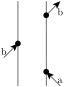

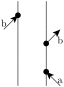

In [18]:
pulse_arrival_times = [0,1]
time_ordered_diagrams = tpe.get_diagrams(pulse_arrival_times)
tpe.display_diagrams(time_ordered_diagrams)
diagram_save_folder = os.path.join(folder,'diagrams')
os.makedirs(diagram_save_folder,exist_ok=True)
tpe.save_diagrams(time_ordered_diagrams,folder_name=diagram_save_folder)
# as you can see below, these are double-sided diagrams. For closed systems, we need 1-sided diagrams:
wavefunction_time_ordered_diagrams = tpe.get_wavefunction_diagrams(pulse_arrival_times)

NOTE: there are two diagrams that must be calculated with finite pulses when calculations are done using density matrices (open systems).  However, time-ordering between bra and ket sides are not important for wavefunction calculations (closed systems), and so the above represents only 1 Feynman Diagram for closed systems.

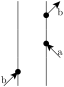

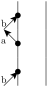

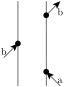

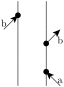

In [19]:
# Note that at tau = 0, all of the following diagrams will be simulated by default
pulse_arrival_times = [0,0]
all_diagrams = tpe.get_diagrams(pulse_arrival_times)
tpe.display_diagrams(all_diagrams)

In [20]:
# To simulate the signal using all diagrams (ufss only simulates overlap diagrams when the pulses overlap)
full_signal = tpe.calculate_signal_all_delays()

# To force ufss to simulate only the time-ordered diagrams even when pulses overlap, use
time_ordered_signal = tpe.calculate_diagrams_all_delays(wavefunction_time_ordered_diagrams)

Note: the methods "calculate_signal_all_delays" and "calculate_diagrams_all_delays" automatically set the local oscillator arrival time to be coincident with the last pulse (in this case with the second pulse).  Let me know if you would like the flexibility to change this behavior.  I don't think it will be necessary, because taking the DFT of the output frequency resolved signal gives the convolution of the signal field with the local oscillator.

In [21]:
# signals are different at tau = 0:
print(np.allclose(full_signal[0,:],time_ordered_signal[0,:]))
# signals are the same for all other values of tau:
print(np.allclose(full_signal[1:,:],time_ordered_signal[1:,:]))

# Keep in mind that with finite pulses, the overlap diagrams contribute at more values of tau!

True
False


<IPython.core.display.Javascript object>


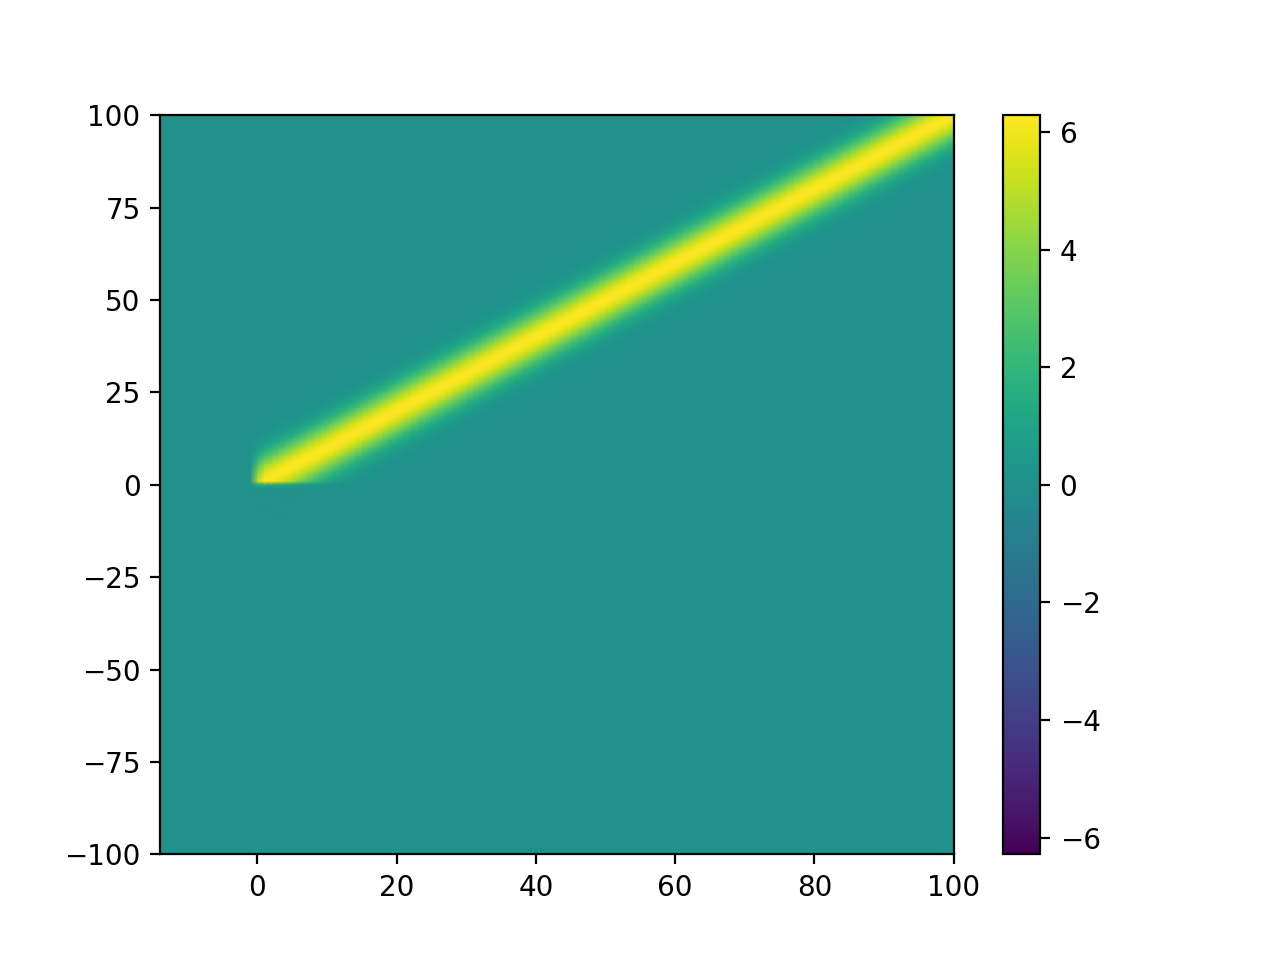

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1822638b70>)

In [22]:
# to get the data as a function of both tau and t (t being the ring-down of the photon echo signal), use
t, full_sig_tau_t = ft(tpe.w,full_signal,axis=1)
blur_sigma = 1/0.2 # I believe this is the value you use in your text document

# In the impulsive case all we need to do is this! (Note for finite pulses we will need to do some kind of
# averaging, as you have done in your uploaded code)
full_sig_tau_t = full_sig_tau_t * np.exp(-(t[np.newaxis,:]-tau[:,np.newaxis])**2/(2*blur_sigma**2))

ufss.signals.plot2D(tau,t,full_sig_tau_t,part='real',colormap='viridis')

### Finite pulses

In [23]:
#tpe is short for two-pulse echo
tpe = ufss.Wavepackets(folder,detection_type='complex_polarization')

# defining the impulsive pulses in the RWA
c = 1 # center frequency ofthe laser pulse
sigma1 = 1
sigma2 = 1 #can be different
Delta = 10
M = 21
t1 = np.linspace(-Delta/2,Delta/2,num=M) * sigma1

pulse1 = ufss.gaussian(t1,sigma1) # can be anything you want, I am just using a built-in Gaussian

t2 = np.linspace(-Delta/2,Delta/2,num=M) * sigma2 # can be different than t1 (different number of points, etc.)

pulse2 = ufss.gaussian(t2,sigma2) # can be anything you want, and does not have to be the same as pulse1

lo = np.array([1]) # local oscillator amplitude is 1
lo_t = np.array([0]) # impulsive limit, nonzero at a single time point

tpe.set_efields([t1,t2,t2],[pulse1,pulse2,pulse2],[c,c,c],pmc) #use same pmc as previous

tpe.set_efields([t1,t2,lo_t],[pulse1,pulse2,lo],[c,c,c],pmc)

tpe.set_polarization_sequence(pulse_polarizations)


tpe.maximum_manifold = 1 # This tells ufss not to try to calculate something like excited-state absorption

gamma = 0.2
dt = 1
tpe.gamma_res = 20 # default value for this is 6.91
tpe.set_t(gamma,dt=dt)

tau = tpe.t.copy()[tpe.t > -15]
tpe.set_pulse_delays([tau])

<IPython.core.display.Javascript object>


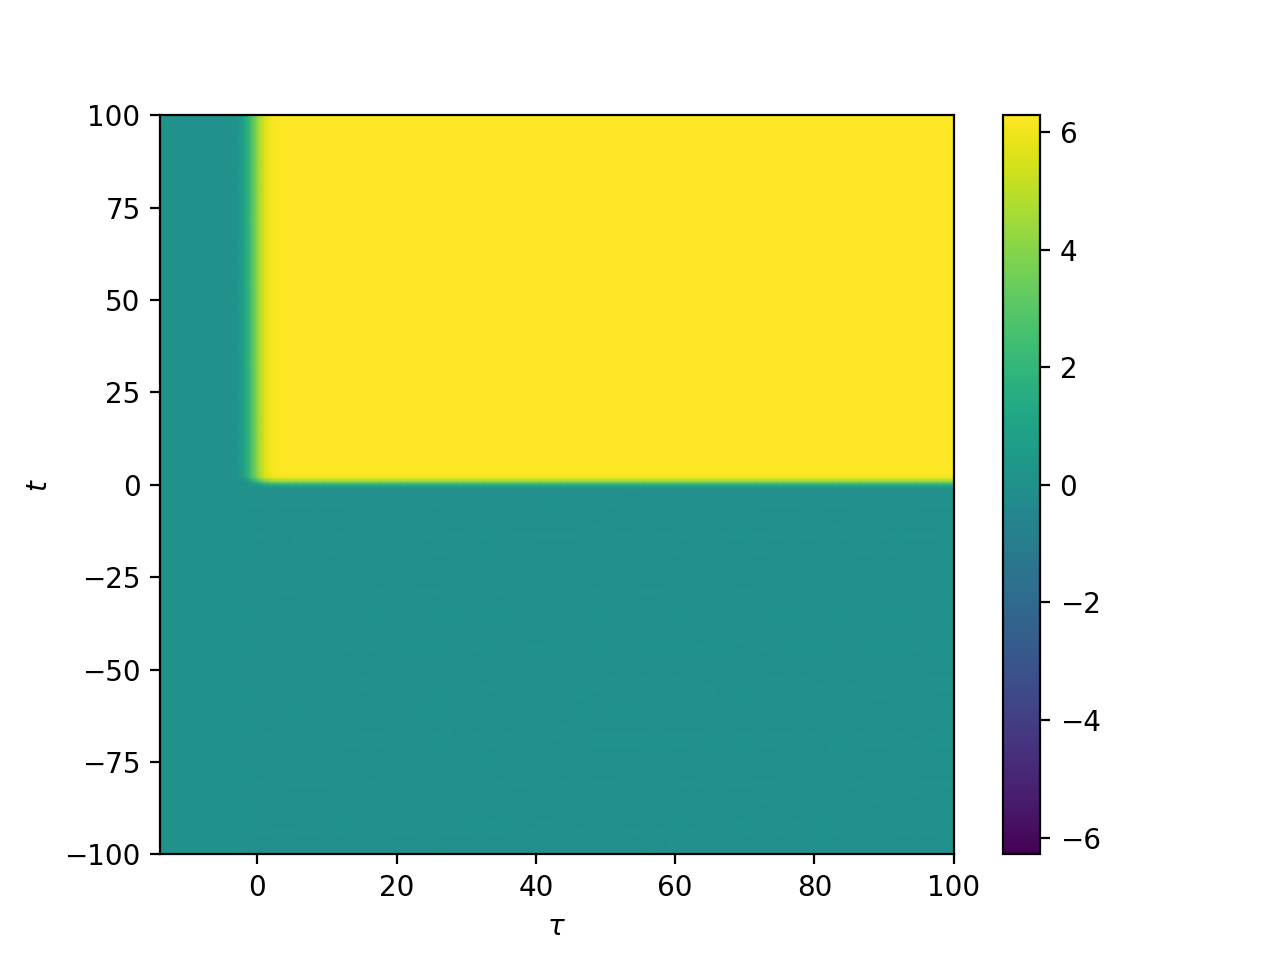

Text(0, 0.5, '$t$')

In [24]:
full_signal = tpe.calculate_signal_all_delays()

t, full_sig_tau_t = ft(tpe.w,full_signal,axis=1)

# unfortunately have to use recalculate many times to get inhomogeneous broadening

# without broadening:

ufss.signals.plot2D(tau,t,full_sig_tau_t,part='real',colormap='viridis')
plt.xlabel(r'$\tau$')
plt.ylabel('$t$')

### $tau = t$

The setup is nearly identical, except that we will call detection_type = 'integrated_polarization', and we will not set pulse delays.  We will handle the pulse arrival times manually

In [25]:
#tpe is short for two-pulse echo
tpe = ufss.Wavepackets(folder,detection_type='integrated_polarization')

# defining the impulsive pulses in the RWA
c = 1 # center frequency ofthe laser pulse
sigma1 = 1
sigma2 = 1 #can be different
Delta = 10
M = 21
t1 = np.linspace(-Delta/2,Delta/2,num=M) * sigma1

pulse1 = ufss.gaussian(t1,sigma1) # can be anything you want, I am just using a built-in Gaussian

t2 = np.linspace(-Delta/2,Delta/2,num=M) * sigma2 # can be different than t1 (different number of points, etc.)

pulse2 = ufss.gaussian(t2,sigma2) # can be anything you want, and does not have to be the same as pulse1

lo = ufss.gaussian(t1,sigma1) # currently doesn't support an impulsive local oscillator
lo_t = t1 # impulsive limit, nonzero at a single time point

tpe.set_efields([t1,t2,t2],[pulse1,pulse2,pulse2],[c,c,c],pmc) #use same pmc as previous

#tpe.set_efields([t1,t2,lo_t],[pulse1,pulse2,lo],[c,c,c],pmc)

tpe.set_polarization_sequence(pulse_polarizations)


tpe.maximum_manifold = 1 # This tells ufss not to try to calculate something like excited-state absorption

gamma = 0.2
dt = 1
tpe.gamma_res = 20 # default value for this is 6.91
tpe.set_t(gamma,dt=dt)

tau = tpe.t.copy()[tpe.t > -15]

The following part is new!

In [26]:
signal = np.zeros(tau.size,dtype='complex')
tpe.return_complex_signal = True #This is a flag to get the full complex signal
for i in range(tau.size):
    pulse_delays = [0,tau[i],2*tau[i]]
    signal[i] = tpe.calculate_signal(pulse_delays)

<IPython.core.display.Javascript object>


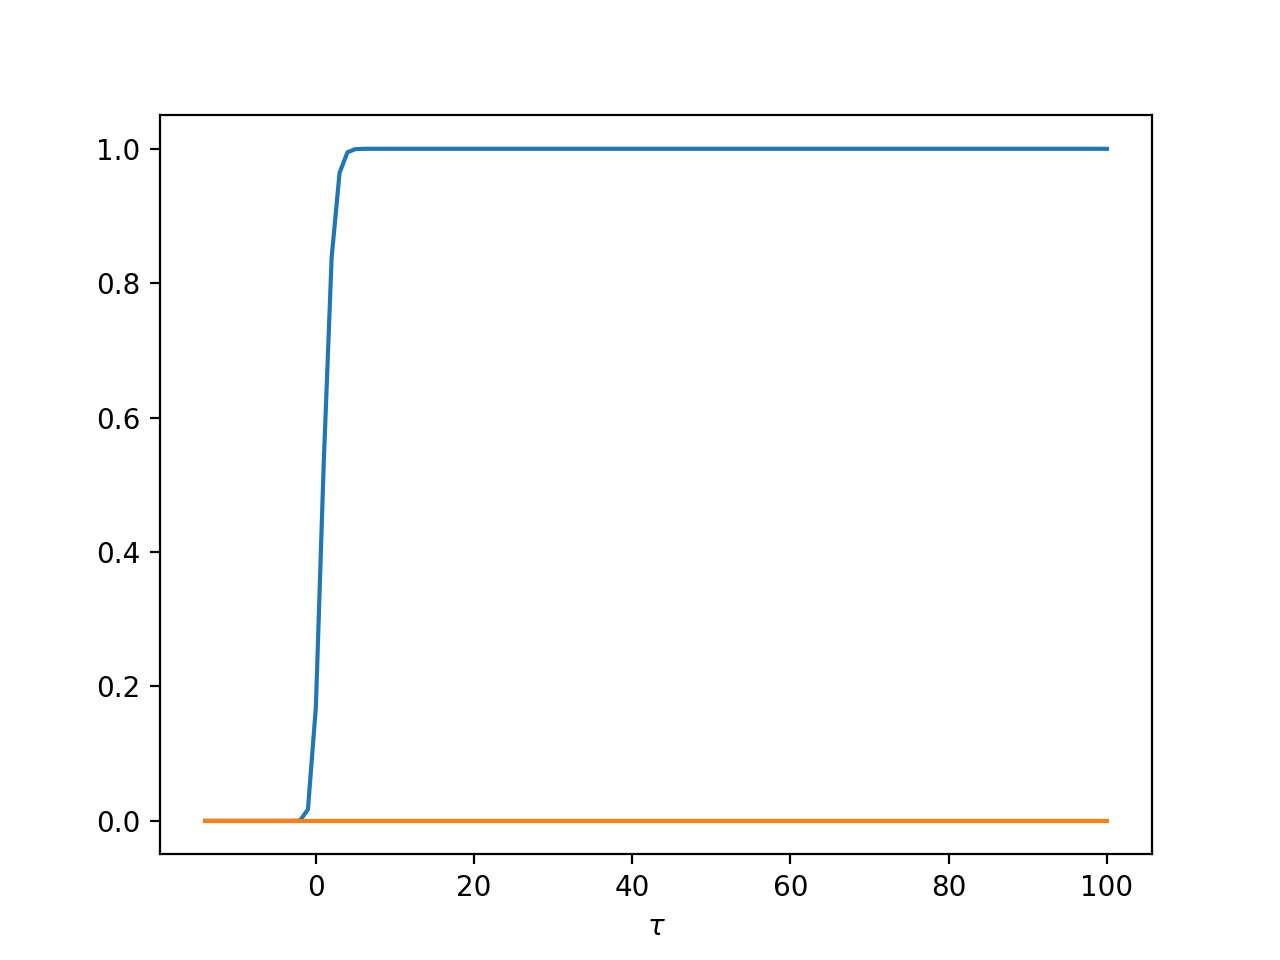

Text(0.5, 0, '$\\tau$')

In [27]:
# Note the signal is off by a factor of 2pi compared to above, this has to do with the way the 
# 'integrated_polarization' detection scheme is defined relative to the 'complex_polarization' version
# it's not an indication of something fundamentally wrong, but I should unify them!
plt.figure()
plt.plot(tau,np.real(signal))
plt.plot(tau,np.imag(signal))
plt.xlabel(r'$\tau$')

## Old code
The following won't run anymore

In [ ]:
full_sig_tau_T_wt = re.calculate_signal_all_delays()
# the signal returned is the signal as a function of tau, T and the fourier conjugate of t -> omega_t
# inverse fourier transform to get as a function of t:
t, full_sig_tau_T_t = ift(re.w,full_sig_tau_T_wt,axis=2)
# add a gaussian linewidth
blur_sigma = 25
full_sig_tau_T_t *= np.exp(-(tau[:,np.newaxis,np.newaxis])**2/(2*blur_sigma**2))
full_sig_tau_T_t *= np.exp(-(t[np.newaxis,np.newaxis,:])**2/(2*blur_sigma**2))
wtau, full_sig_wtau_T_t = ft(tau,full_sig_tau_T_t,axis=0)
wt, full_sig_wtau_T_wt = ft(t,full_sig_wtau_T_t,axis=2)

# Plot result
ufss.signals.plot2D(wtau,wt,full_sig_wtau_T_wt[:,0,:],part='abs')

<IPython.core.display.Javascript object>


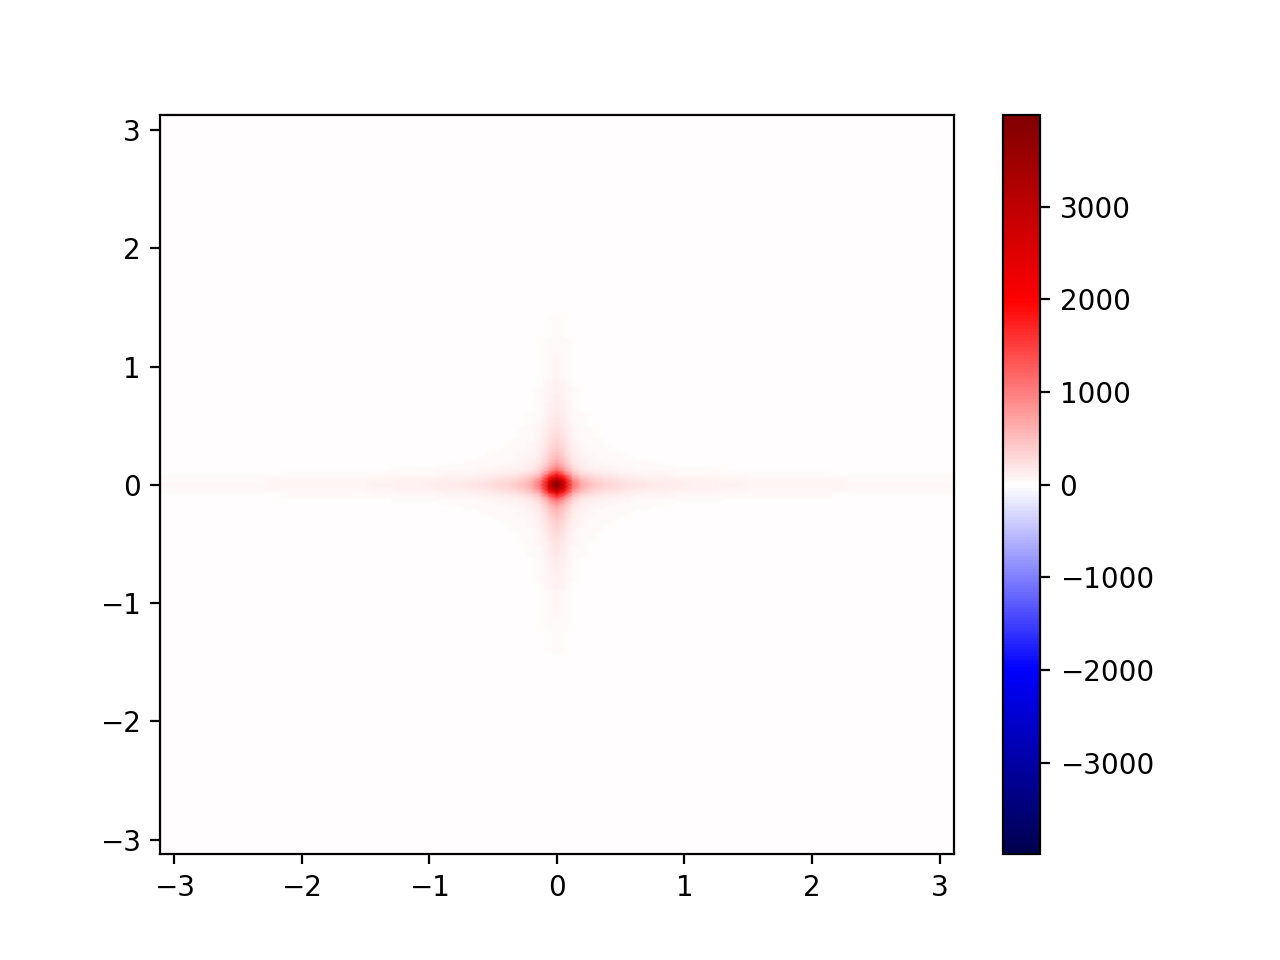

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x183c1bea20>)

In [141]:
re.set_polarization_sequence(['r','r','r','r'])

full_sig_tau_T_wt = re.calculate_signal_all_delays()
# the signal returned is the signal as a function of tau, T and the fourier conjugate of t -> omega_t
# inverse fourier transform to get as a function of t:
t, full_sig_tau_T_t = ift(re.w,full_sig_tau_T_wt,axis=2)
# add a gaussian linewidth
blur_sigma = 25
full_sig_tau_T_t *= np.exp(-(tau[:,np.newaxis,np.newaxis])**2/(2*blur_sigma**2))
full_sig_tau_T_t *= np.exp(-(t[np.newaxis,np.newaxis,:])**2/(2*blur_sigma**2))
wtau, full_sig_wtau_T_t = ft(tau,full_sig_tau_T_t,axis=0)
wt, full_sig_wtau_T_wt = ft(t,full_sig_wtau_T_t,axis=2)

# Plot result
ufss.signals.plot2D(wtau,wt,full_sig_wtau_T_wt[:,0,:],part='abs')

<IPython.core.display.Javascript object>


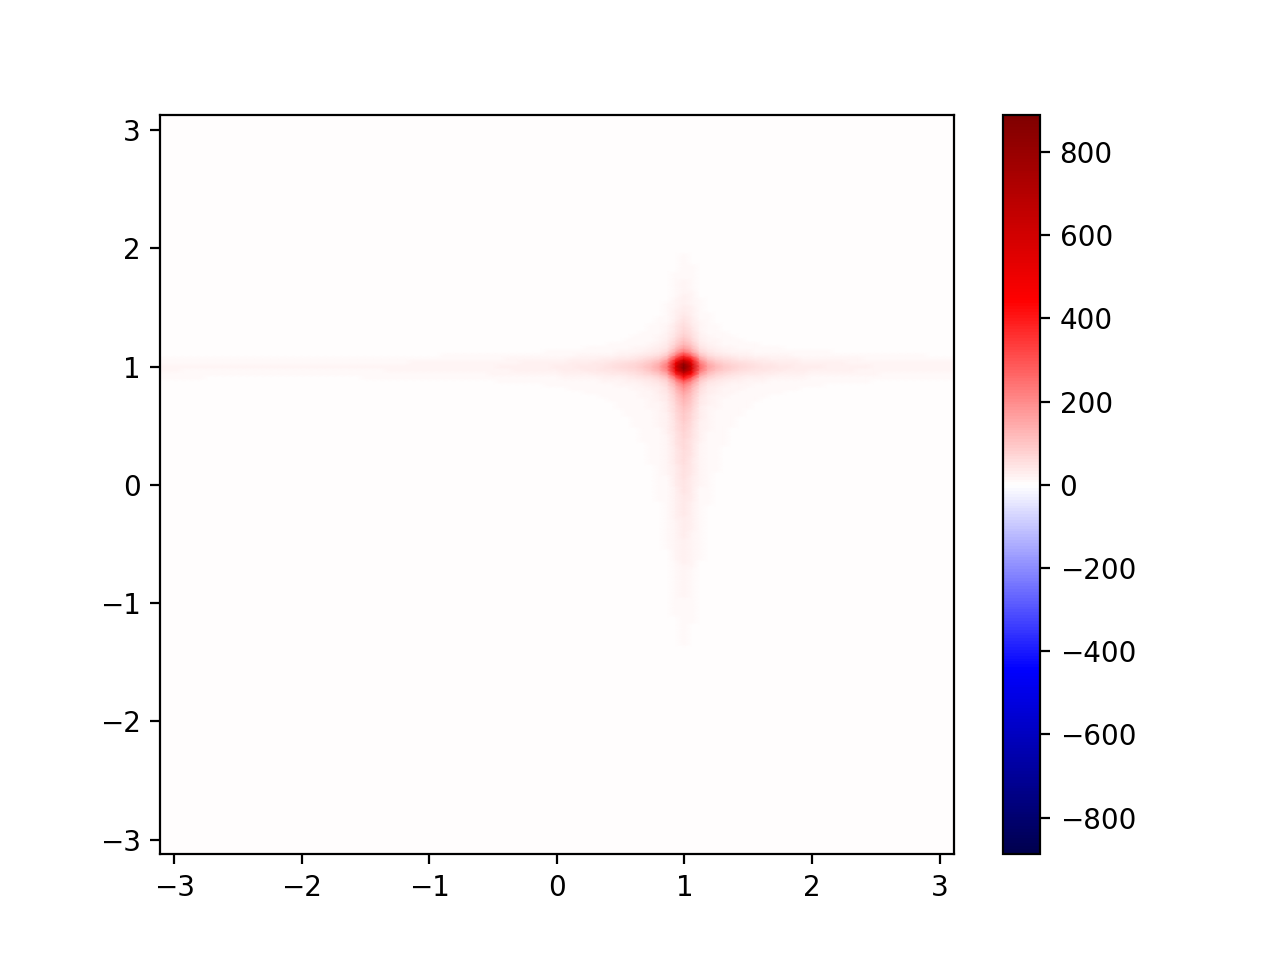

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x183c7db908>)

In [142]:
re.set_polarization_sequence(['l','l','l','l'])

full_sig_tau_T_wt = re.calculate_signal_all_delays()
# the signal returned is the signal as a function of tau, T and the fourier conjugate of t -> omega_t
# inverse fourier transform to get as a function of t:
t, full_sig_tau_T_t = ift(re.w,full_sig_tau_T_wt,axis=2)
# add a gaussian linewidth
blur_sigma = 25
full_sig_tau_T_t *= np.exp(-(tau[:,np.newaxis,np.newaxis])**2/(2*blur_sigma**2))
full_sig_tau_T_t *= np.exp(-(t[np.newaxis,np.newaxis,:])**2/(2*blur_sigma**2))
wtau, full_sig_wtau_T_t = ft(tau,full_sig_tau_T_t,axis=0)
wt, full_sig_wtau_T_wt = ft(t,full_sig_wtau_T_t,axis=2)

# Plot result
ufss.signals.plot2D(wtau,wt,full_sig_wtau_T_wt[:,0,:],part='abs')